In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score

# Подготовка датасета

In [2]:
data = pd.read_csv(os.getcwd() + '\data\spam.csv', encoding='latin-1')

In [3]:
df = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
df['v1'] = df['v1'].map({'spam': 0, 'ham': 1})
df.head(10)

,v1,v2
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."
5,0,FreeMsg Hey there darling it's been 3 week's n...
6,1,Even my brother is not like to speak with me. ...
7,1,As per your request 'Melle Melle (Oru Minnamin...
8,0,WINNER!! As a valued network customer you have...
9,0,Had your mobile 11 months or more? U R entitle...


# Смотрим распределение целевой переменной

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


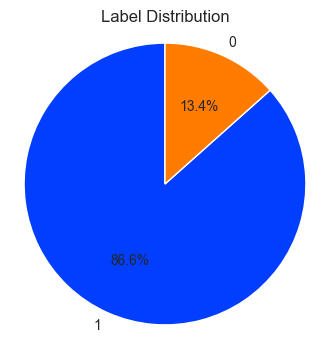

In [5]:
v_ct = df['v1'].value_counts()
palette_color = sns.color_palette('bright') 
sns.set_style("darkgrid")
plt.figure(figsize=(4, 4))
plt.pie(v_ct, labels=v_ct.index, autopct = '%1.1f%%', startangle = 90, colors=palette_color)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()

In [6]:
df.groupby('v1')['v2'].count()

v1
0     747
1    4825
Name: v2, dtype: int64

# Обработка сообщений

In [7]:
wnl = WordNetLemmatizer()
stopwords_eng = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    tokens = [wnl.lemmatize(word) for word in words if word not in stopwords_eng]
    return ' '.join(tokens)

Привели сообщения к нижнему регистру, удалили знаки препинания и цифры, лемматизировали "лексически значимые" слова, от остальных избавились

In [8]:
df['text'] = df['v2'].apply(preprocess_text)
df

,v1,v2,text
0,1,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,1,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,1,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though
...,...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...,nd time tried contact u u pound prize claim ea...
5568,1,Will Ì_ b going to esplanade fr home?,b going esplanade fr home
5569,1,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion
5570,1,The guy did some bitching but I acted like i'd...,guy bitching acted like id interested buying s...


In [9]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])
y = df['v1']

Векторизовали корпус с помощью TF-IDF

# Разделение датасета на тренировочную и тестовую выборки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Обучение модели наивного байеса

In [11]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [12]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

In [13]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

roc-auc: 0.9876765456428914
precision: 0.9527638190954774
recall: 1.0
f1: 0.9758106021616058


- Значение ROC-AUC близкое к 1 указывает на то, что модель хорошо различает классы (спам и не спам);
- Высокая точность указывает на то, что модель делает очень мало ложных срабатываний;
- Единичная полнота говорит о том, что модель не пропускает ни одно спам-сообщение.